In [1]:
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install pybullet
!pip install tf-agents[reverb]

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:8 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [62.2 kB]
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
Get:13 http://archiv

In [2]:
pip install atari-py

In [3]:
import numpy as np
import base64
import imageio
import os
import reverb
import tempfile
import IPython
import PIL
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf

from tf_agents.agents.ddpg import critic_network
from tf_agents.agents.sac import sac_agent
from tf_agents.agents.sac import tanh_normal_projection_network
from tf_agents.environments import suite_pybullet
from tf_agents.metrics import py_metrics
from tf_agents.networks import actor_distribution_network
from tf_agents.policies import greedy_policy
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_py_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.train import actor
from tf_agents.train import learner
from tf_agents.train import triggers
from tf_agents.train.utils import spec_utils
from tf_agents.train.utils import strategy_utils
from tf_agents.train.utils import train_utils

tempdir = tempfile.gettempdir()


In [4]:
# Базовая среда
env_minitaur = 'MinitaurBulletEnv-v0'

current_dir=/usr/local/lib/python3.7/dist-packages/pybullet_envs/bullet
urdf_root=/usr/local/lib/python3.7/dist-packages/pybullet_data


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


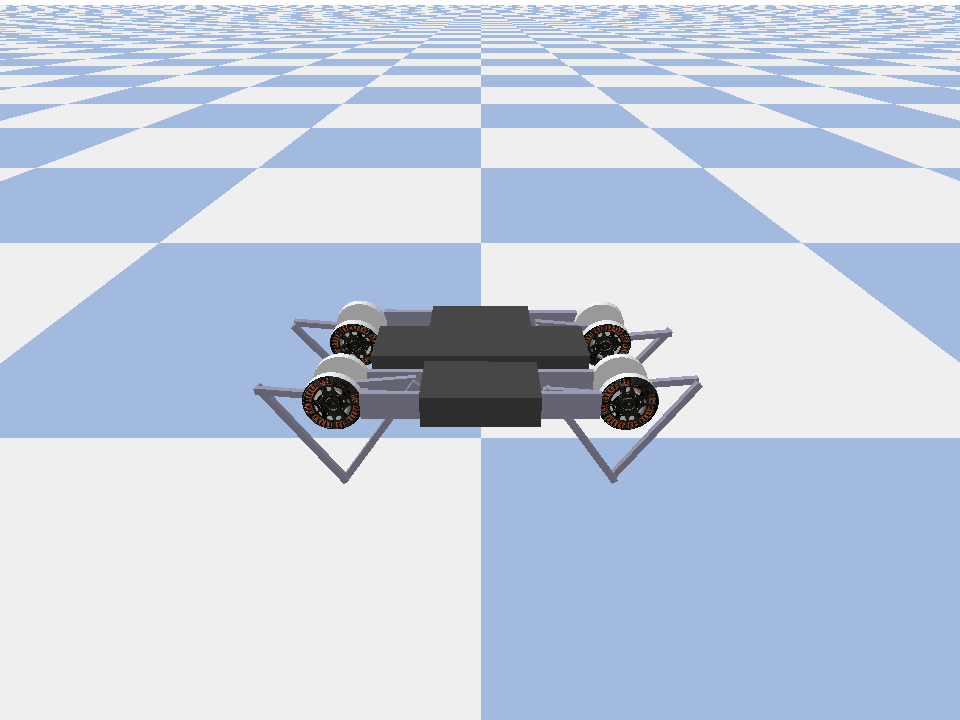

In [5]:
env = suite_pybullet.load(env_minitaur)
env.reset()
Image.fromarray(env.render())

In [7]:
# Параметры конфигурации
n_iteration = 200000   # 100000
steps_iterations = 1
initial_steps = 10000
replay_buffer_capacity = 10000
batch_size = 256
target_update_tau = 0.005
target_update_period = 1
discount_past_rewards = 0.99
reward_param = 1.0
actor_params = (256, 256)
critic_params = (256, 256)
interval_log = 2500   # 5000
n_eval_episodes = 20
interval_eval = 10000
save_interval = 5000


In [8]:
# Информация о среде
print(f'Спецификация наблюдения: {env.time_step_spec().observation}')
print()
print(f'Спецификация действия: {env.action_spec()}')

Спецификация наблюдения: BoundedArraySpec(shape=(28,), dtype=dtype('float32'), name='observation', minimum=[  -3.1515927   -3.1515927   -3.1515927   -3.1515927   -3.1515927
   -3.1515927   -3.1515927   -3.1515927 -167.72488   -167.72488
 -167.72488   -167.72488   -167.72488   -167.72488   -167.72488
 -167.72488     -5.71        -5.71        -5.71        -5.71
   -5.71        -5.71        -5.71        -5.71        -1.01
   -1.01        -1.01        -1.01     ], maximum=[  3.1515927   3.1515927   3.1515927   3.1515927   3.1515927   3.1515927
   3.1515927   3.1515927 167.72488   167.72488   167.72488   167.72488
 167.72488   167.72488   167.72488   167.72488     5.71        5.71
   5.71        5.71        5.71        5.71        5.71        5.71
   1.01        1.01        1.01        1.01     ])

Спецификация действия: BoundedArraySpec(shape=(8,), dtype=dtype('float32'), name='action', minimum=-1.0, maximum=1.0)


In [9]:
# Создаем среды для сбора данных
collect_env = suite_pybullet.load(env_minitaur)
eval_env = suite_pybullet.load(env_minitaur)

urdf_root=/usr/local/lib/python3.7/dist-packages/pybullet_data
urdf_root=/usr/local/lib/python3.7/dist-packages/pybullet_data


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [10]:
# Стратегия
use_gpu = True
strategy = strategy_utils.get_strategy(tpu=False, use_gpu=use_gpu)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [12]:
# Агент
observation_spec, action_spec, time_spec = (spec_utils.get_tensor_specs(collect_env))
with strategy.scope():
    critic_net = critic_network.CriticNetwork(
        (observation_spec, action_spec),
        observation_fc_layer_params=None,
        action_fc_layer_params=None,
        joint_fc_layer_params=critic_params,
        kernel_initializer = 'glorot_uniform',
        last_kernel_initializer = 'glorot_uniform')

In [13]:
# подготовка генерирования действия
with strategy.scope():
    actor_net = actor_distribution_network.ActorDistributionNetwork(
        observation_spec,
        action_spec,
        fc_layer_params = actor_params,
        continuous_projection_net=(tanh_normal_projection_network.TanhNormalProjectionNetwork))

In [14]:
# Создаем экземпляр Агента
with strategy.scope():
    train_step = train_utils.create_train_step()
    
    tf_agent = sac_agent.SacAgent(
    time_spec,
    action_spec,
    actor_network = actor_net,
    critic_network = critic_net,
    actor_optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.0001),
    critic_optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.0001),
    alpha_optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.0001),
    target_update_tau = target_update_tau,
    target_update_period = target_update_period,
    td_errors_loss_fn=tf.math.squared_difference,
    gamma = discount_past_rewards,
    reward_scale_factor = reward_param,
    train_step_counter=train_step)
tf_agent.initialize()

In [15]:
# Создаем буфер воспроизведения
limiter = reverb.rate_limiters.SampleToInsertRatio(samples_per_insert=3.0, 
                                                   min_size_to_sample=3,
                                                   error_buffer=3.0)

In [16]:
table_name = 'uniform_table'
table = reverb.Table(
    table_name,
    max_size = replay_buffer_capacity,
    sampler = reverb.selectors.Uniform(),
    remover = reverb.selectors.Fifo(),
    rate_limiter = reverb.rate_limiters.MinSize(1))
reverb_server = reverb.Server([table])

In [17]:
# Устанавливаем количество наблюдений
reverb_replay = reverb_replay_buffer.ReverbReplayBuffer(
    tf_agent.collect_data_spec,
    sequence_length=2,
    table_name=table_name,
    local_server=reverb_server)

In [18]:
# Генерируем набор данных из буфера воспроизведения
data = reverb_replay.as_dataset(sample_batch_size=batch_size, num_steps=2).prefetch(50)
experience_data = lambda:data

In [19]:
# Политики
tf_eval_policy = tf_agent.policy
eval_policy = py_tf_eager_policy.PyTFEagerPolicy(tf_eval_policy, use_tf_function=True)

In [20]:
tf_collect_policy = tf_agent.collect_policy
collect_policy = py_tf_eager_policy.PyTFEagerPolicy(tf_collect_policy, use_tf_function=True)

In [21]:
# Случайный выбор действия
rand_policy = random_py_policy.RandomPyPolicy(collect_env.time_step_spec(), collect_env.action_spec())

In [22]:
# Создам Актера для управления взаимодействием между политикой и средой
observer = reverb_utils.ReverbAddTrajectoryObserver(
    reverb_replay.py_client,
    table_name,
    sequence_length=2,
    stride_length=1)

In [23]:
# Актер со случайной политикой собирает опыт
initial_actor = actor.Actor(
    collect_env,
    rand_policy,
    train_step,
    steps_per_run=initial_steps,
    observers=[observer])
initial_actor.run()

In [24]:
# Создаем Актера для сбора опыта во время обучения
env_step_metric = py_metrics.EnvironmentSteps()
collect_actor = actor.Actor(
    collect_env,
    collect_policy,
    train_step,
    steps_per_run=1,
    metrics=actor.collect_metrics(10),
    summary_dir=os.path.join(tempdir, learner.TRAIN_DIR),
    observers=[observer, env_step_metric])

In [25]:
# Актер для оценки политики во время обучения
eval_actor = actor.Actor(
    eval_env,
    eval_policy,
    train_step,
    episodes_per_run=n_eval_episodes,
    metrics=actor.eval_metrics(n_eval_episodes),
    summary_dir=os.path.join(tempdir, 'eval'),
)

In [26]:
# Обучение
saved_model_dir = os.path.join(tempdir, learner.POLICY_SAVED_MODEL_DIR)
# сохранение контрольных точек политики агента
learning_triggers = [
                  triggers.PolicySavedModelTrigger(
                      saved_model_dir,
                      tf_agent,
                      train_step,
                      interval=save_interval),
                  triggers.StepPerSecondLogTrigger(train_step, interval=1000),
]

agent_learner = learner.Learner(
    tempdir,
    train_step,
    tf_agent,
    experience_data,
    triggers=learning_triggers
)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: /tmp/policies/policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/policy/assets



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: /tmp/policies/collect_policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/collect_policy/assets



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: /tmp/policies/greedy_policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/greedy_policy/assets


Instructions for updating:
rename to distribute_datasets_from_function


Instructions for updating:
rename to distribute_datasets_from_function


Метрики и оценка

In [27]:
def get_metrics_eval():
    eval_actor.run()
    results = {}
    for metric in eval_actor.metrics:
        results[metric.name] = metric.result()
    return results

metrics = get_metrics_eval()

In [28]:
def log_eval_metrics(step, metrics):
    eval_results = (', ').join(
      '{} = {:.6f}'.format(name, result) for name, result in metrics.items())
    print(f'Шаг= {step}, {eval_results}')
log_eval_metrics(0, metrics)

Шаг= 0, AverageReturn = -0.134386, AverageEpisodeLength = 32.750000


Тренируем Агента

In [29]:
try:
    %%time
except:
    pass

# Сбрасывае шаг обучения
tf_agent.train_step_counter.assign(0)
# Оценка политики агента перед обучением 
avg_return = get_metrics_eval()['AverageReturn']
returns = [avg_return]

for _ in range(n_iteration):
    collect_actor.run()                         # Тренируем
    loss_info = agent_learner.run(iterations=1)
    step = agent_learner.train_step_numpy       # Оцениваем
    
    if interval_eval and step % interval_eval == 0:
        metrics = get_metrics_eval()
        log_eval_metrics(step, metrics)
        returns.append(metrics['AverageReturn'])

    if interval_log and step % interval_log == 0:
        print(f' Шаг= {step} \n Потери= {loss_info.loss.numpy()}')

observer.close()
reverb_server.stop()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs
 Шаг= 2500 /n Потери= -33.075382232666016
 Шаг= 5000 /n Потери= -70.48687744140625
 Шаг= 7500 /n Потери= -95.58252716064453
Шаг= 10000, AverageReturn = -0.384494, AverageEpisodeLength = 296.100006
 Шаг= 10000 /n Потери= -109.53326416015625
 Шаг= 12500 /n Потери= -110.9465560913086
 Шаг= 15000 /n Потери= -106.75872802734375
 Шаг= 17500 /n Потери= -83.01505279541016
Шаг= 20000, AverageReturn = -1.206456, AverageEpisodeLength = 403.250000
 Шаг= 20000 /n Потери= -80.55341339111328
 Шаг= 22500 /n Потери= -67.8987808227539
 Шаг= 25000 /n Потери= -57.905609130859375
 Шаг= 27500 /n Потери= -47.94282913208008
Шаг= 30000, AverageReturn = -1.146564, AverageEpisodeLength = 429.100006
 Шаг= 30000 /n Потери= -38.4375
 Шаг= 32500 /n Потери= -33.45813751220703
 Шаг= 35000 /n Потери= -31.63765525817871
 Шаг= 37500 /n Потери= -25.49227523803711
Шаг= 40000, AverageReturn = -1.283925, AverageEpisodeLength = 394.149994
 Шаг= 40000 /n Потери= -

Визуализация

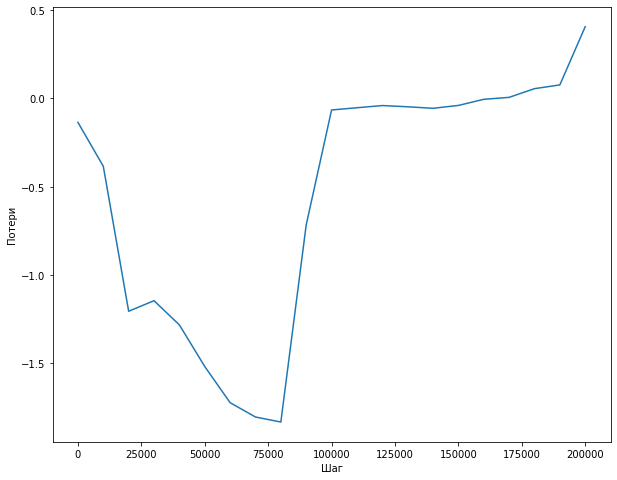

In [34]:
steps = range(0, n_iteration + 1, interval_eval)
plt.figure(figsize=(10, 8))
plt.plot(steps, returns)
plt.ylabel('Потери')
plt.xlabel('Шаг')

plt.ylim()
plt.show()

In [31]:
def embed_mp4(filename):
  # Встраиваем файл mp4 в записную книжку
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = ''' <video width="640" height="480" controls>
            <source src="data:video/mp4;base64,{0}" type="video/mp4">
            Your browser does not support the video tag.
            </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

Видео

In [35]:
num_episodes = 20
video_filename = 'minitaur.mp4'
with imageio.get_writer(video_filename, fps=60) as video:
  for _ in range(num_episodes):
    time_step = eval_env.reset()
    video.append_data(eval_env.render())
    while not time_step.is_last():
      action_step = eval_actor.policy.action(time_step)
      time_step = eval_env.step(action_step.action)
      video.append_data(eval_env.render())

embed_mp4(video_filename)

Output hidden; open in https://colab.research.google.com to view.